# Tecnológico de Costa Rica
## Programa de Ciencia de Datos
### Prof. Luis Alexander Calvo Valverde

#### Big Data
#### Tarea-3

--- 
Estudiante: José Alberto Raygada Agüero

---

Objetivo
Ejecutar el proceso de extracción de datos y entrenamiento de un modelo en Apache Spark de 
principio a fin.

---

# Resultado planteado:

Se plantea entrenar un modelo de clasificación binaria en Apache Spark, basada en el conjunto de datos del naufragio del Títanic, cuya información de victimas y sobrevivientes se puede obtener en  https://www.kaggle.com/competitions/titanic y que he condensado en el archivo que denomino "titanic_db.csv". Primeramente se efectuará la lectura y limpieza de los datos, para luego realizar el análisis descriptivo de la información, el almacenamiento intermedio en PostgreSQL y, finalmente, el entrenamiento y ejecución del modelo de clasificción binaria.


# Lectura y limpieza

Como hemos visto en módulos anteriores, una de las tareas más comunes al procesar datos es el ajuste y limpieza de los datos. Este ejemplo refleja esta situación. En las celdas siguientes leeremos los datos de un archivo CSV y realizaremos diferentes pasos para poder cargar los datos a una tabla en PostgreSQL que almacenará el conjunto de datos en su forma deseada para abordar el análisis.

In [1]:
import findspark
findspark.init()

import pyspark
import pyspark.sql.functions as f

from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

# Dictionary
# "Pclass" Ticket class
# "SibSp" of siblings / spouses aboard the Titanic
# "Parch" of parents / children aboard the Titanic
# "Embarked" Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton
# "Survived" 0 = No, 1 = Yes

titanic_df = spark \
    .read \
    .format("csv") \
    .option("path", "titanic_db.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("PassengerId", IntegerType()),
                StructField("Pclass", StringType()),
                StructField("Name", StringType()),
                StructField("Sex", StringType()),
                StructField("Age", FloatType()),
                StructField("SibSp", IntegerType()),
                StructField("Parch", IntegerType()), 
                StructField("Ticket", StringType()),
                StructField("Fare", FloatType()),
                StructField("Cabin", StringType()),
                StructField("Embarked", StringType()),
                StructField("Survived", IntegerType())])) \
    .load()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/05 23:24:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Survived: integer (nullable = true)



In [4]:
titanic_df.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Survived|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|       0|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|       1|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|       1|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|       1|
|          5|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|       0|
|          6|     3|    Moran, Mr. James|  male|null|    0|    0|          33087

# Eliminación de columnas que no aportan valor

Me parece que la columna de 'Cabin' no es relevante para el análisis por lo que se procede a eliminarla

In [5]:
titanic_df = titanic_df.drop('Cabin')

In [6]:
titanic_df.summary().show()

+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+--------+-------------------+
|summary|      PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|              Fare|Embarked|           Survived|
+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+--------+-------------------+
|  count|             1309|              1309|                1309|  1309|              1046|              1309|              1309|              1309|              1308|    1307|               1309|
|   mean|            655.0| 2.294881588999236|                null|  null|29.881137667305726|0.4988540870893812|0.3850267379679144| 249039.1368861024| 33.29547938203228|    null|0.37738731856378915|
| std

# Identificando los datos faltantes

In [7]:
for i in titanic_df.columns:
    print(i,titanic_df.where(f.col(i).isNull()).count())

PassengerId 0
Pclass 0
Name 0
Sex 0
Age 263
SibSp 0
Parch 0
Ticket 0
Fare 1
Embarked 2
Survived 0


## Completando los datos faltantes de 'Age'

In [8]:
titanic_df = titanic_df.withColumn("ageImputed",f.when(f.col("Age").isNull(),1).otherwise(0))

In [9]:
meanage = titanic_df.select(f.mean(f.col('Age'))).collect()[0][0]
titanic_df = titanic_df.withColumn('Age',f.when(f.col('Age').isNull(),meanage).otherwise(titanic_df['Age']))

## Completando los datos faltantes de 'Fare'

In [10]:
titanic_df = titanic_df.withColumn("fareImputed",f.when(f.col("Fare").isNull(),1).otherwise(0))

In [11]:
meanage = titanic_df.select(f.mean(f.col('Fare'))).collect()[0][0]
titanic_df = titanic_df.withColumn('Fare',f.when(f.col('Fare').isNull(),meanage).otherwise(titanic_df['Fare']))

## Completando los datos faltantes y depurando datos de 'Embarked'

In [12]:
titanic_df.groupby('embarked').count().sort(f.col("count").desc()).show()

+--------+-----+
|embarked|count|
+--------+-----+
|       S|  914|
|       C|  270|
|       Q|  123|
|    null|    2|
+--------+-----+



In [13]:
# Debido a que la embarcación más común es 'S' (Southampton), sustituimos con ese valor

titanic_df = titanic_df.withColumn('Embarked',f.when(f.col('Embarked').isNull(),'S').otherwise(titanic_df['Embarked']))

In [14]:
titanic_df.show()

+-----------+------+--------------------+------+------------------+-----+-----+----------------+------------------+--------+--------+----------+-----------+
|PassengerId|Pclass|                Name|   Sex|               Age|SibSp|Parch|          Ticket|              Fare|Embarked|Survived|ageImputed|fareImputed|
+-----------+------+--------------------+------+------------------+-----+-----+----------------+------------------+--------+--------+----------+-----------+
|          1|     3|Braund, Mr. Owen ...|  male|              22.0|    1|    0|       A/5 21171|              7.25|       S|       0|         0|          0|
|          2|     1|Cumings, Mrs. Joh...|female|              38.0|    1|    0|        PC 17599|  71.2833023071289|       C|       1|         0|          0|
|          3|     3|Heikkinen, Miss. ...|female|              26.0|    0|    0|STON/O2. 3101282| 7.925000190734863|       S|       1|         0|          0|
|          4|     1|Futrelle, Mrs. Ja...|female|          

In [15]:
for i in titanic_df.columns:
    print(i,titanic_df.where(f.col(i).isNull()).count())

PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Embarked 0
Survived 0
ageImputed 0
fareImputed 0


In [16]:
# Seguidamente procedo a seleccionar un subconjunto de las columnas de interés y el objectivo que es la columna de 'Survived'

columns_kept = ['PassengerId','Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
                'Fare', 'Embarked', 'Survived']

selected_columns_df = titanic_df.select(columns_kept)

selected_columns_df.show()

+-----------+------+------+------------------+-----+-----+------------------+--------+--------+
|PassengerId|Pclass|   Sex|               Age|SibSp|Parch|              Fare|Embarked|Survived|
+-----------+------+------+------------------+-----+-----+------------------+--------+--------+
|          1|     3|  male|              22.0|    1|    0|              7.25|       S|       0|
|          2|     1|female|              38.0|    1|    0|  71.2833023071289|       C|       1|
|          3|     3|female|              26.0|    0|    0| 7.925000190734863|       S|       1|
|          4|     1|female|              35.0|    1|    0|53.099998474121094|       S|       1|
|          5|     3|  male|              35.0|    0|    0| 8.050000190734863|       S|       0|
|          6|     3|  male|29.881137667305726|    0|    0|  8.45829963684082|       Q|       0|
|          7|     1|  male|              54.0|    0|    0| 51.86249923706055|       S|       0|
|          8|     3|  male|             

In [17]:
# Se procede a almacenar el conjunto de datos limpio en la base de datos

selected_columns_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "titanic_data") \
    .save()

# Inspección de los datos

Previo a entrenar el modelo procedemos a realizar la descripción de los datos como base para evaluar el tipo de problema que queremos resolver. Para hacerlo traemos los datos previamente almacenados en la base de datos de postgreSQL:

In [18]:
# Cargamos el conjunto de datos desde la base de datos de postgreSQL

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "titanic_data") \
    .load()
df.show()

+-----------+------+------+------------------+-----+-----+------------------+--------+--------+
|PassengerId|Pclass|   Sex|               Age|SibSp|Parch|              Fare|Embarked|Survived|
+-----------+------+------+------------------+-----+-----+------------------+--------+--------+
|          1|     3|  male|              22.0|    1|    0|              7.25|       S|       0|
|          2|     1|female|              38.0|    1|    0|  71.2833023071289|       C|       1|
|          3|     3|female|              26.0|    0|    0| 7.925000190734863|       S|       1|
|          4|     1|female|              35.0|    1|    0|53.099998474121094|       S|       1|
|          5|     3|  male|              35.0|    0|    0| 8.050000190734863|       S|       0|
|          6|     3|  male|29.881137667305726|    0|    0|  8.45829963684082|       Q|       0|
|          7|     1|  male|              54.0|    0|    0| 51.86249923706055|       S|       0|
|          8|     3|  male|             

# Depuración de la información categórica (Pclass, Sex y Embarked)

In [19]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

# Crear el OneHotEncoder para la variable 'Embarked'
# ------------------------------------------------------------------
distinct_values = df.select("Embarked")\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()

# Para cada una de los valores recopilados crear una nueva columna
for distinct_value in distinct_values:
    function = udf(lambda item: 
                   1 if item == distinct_value else 0, 
                   IntegerType())
    new_column_name = "Embarked"+'_'+distinct_value
    df = df.withColumn(new_column_name, function(col("Embarked")))

df = df \
    .withColumn('Embarked_C', df['Embarked_C'].cast(FloatType())) \
    .withColumn('Embarked_Q', df['Embarked_Q'].cast(FloatType())) \
    .withColumn('Embarked_S', df['Embarked_S'].cast(FloatType())) \
    
df.select(['Embarked','Embarked_C','Embarked_Q','Embarked_S']).show()


+--------+----------+----------+----------+
|Embarked|Embarked_C|Embarked_Q|Embarked_S|
+--------+----------+----------+----------+
|       S|       0.0|       0.0|       1.0|
|       C|       1.0|       0.0|       0.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       Q|       0.0|       1.0|       0.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       C|       1.0|       0.0|       0.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       Q|       0.0|       1.0|       0.0|
|       S|       0.0|       0.0|       1.0|
|       S|       0.0|       0.0|       1.0|
|       C|       1.0|       0.0|

In [20]:
# Crear el OneHotEncoder para la variable 'Pclas'
# ------------------------------------------------------------------
distinct_values = df.select("Pclass")\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()

# Para cada una de los valores recopilados crear una nueva columna
for distinct_value in distinct_values:
    function = udf(lambda item: 
                   1 if item == distinct_value else 0, 
                   IntegerType())
    new_column_name = "Pclass"+'_'+distinct_value
    df = df.withColumn(new_column_name, function(col("Pclass")))
    
df = df \
    .withColumn('Pclass_1', df['Pclass_1'].cast(FloatType())) \
    .withColumn('Pclass_2', df['Pclass_2'].cast(FloatType())) \
    .withColumn('Pclass_3', df['Pclass_3'].cast(FloatType())) \

df.select(['Pclass','Pclass_1','Pclass_2','Pclass_3']).show()


+------+--------+--------+--------+
|Pclass|Pclass_1|Pclass_2|Pclass_3|
+------+--------+--------+--------+
|     3|     0.0|     0.0|     1.0|
|     1|     1.0|     0.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     1|     1.0|     0.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     3|     0.0|     0.0|     1.0|
|     1|     1.0|     0.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     3|     0.0|     0.0|     1.0|
|     2|     0.0|     1.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     1|     1.0|     0.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     3|     0.0|     0.0|     1.0|
|     3|     0.0|     0.0|     1.0|
|     2|     0.0|     1.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     2|     0.0|     1.0|     0.0|
|     3|     0.0|     0.0|     1.0|
|     3|     0.0|     0.0|     1.0|
+------+--------+--------+--------+
only showing top 20 rows



In [21]:
# Crear el OneHotEncoder para la variable 'Sex'
# ------------------------------------------------------------------
distinct_values = df.select("Sex")\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()

# Para cada una de los valores recopilados crear una nueva columna
for distinct_value in distinct_values:
    function = udf(lambda item: 
                   1 if item == distinct_value else 0, 
                   IntegerType())
    new_column_name = "Sex"+'_'+distinct_value
    df = df.withColumn(new_column_name, function(col("Sex")))
    
    
df = df \
    .withColumn('Sex_female', df['Sex_female'].cast(FloatType())) \
    .withColumn('Sex_male', df['Sex_male'].cast(FloatType())) \


df.select(['Sex','Sex_female','Sex_male']).show()


+------+----------+--------+
|   Sex|Sex_female|Sex_male|
+------+----------+--------+
|  male|       0.0|     1.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
|  male|       0.0|     1.0|
|  male|       0.0|     1.0|
|  male|       0.0|     1.0|
|  male|       0.0|     1.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
|  male|       0.0|     1.0|
|  male|       0.0|     1.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
|  male|       0.0|     1.0|
|  male|       0.0|     1.0|
|female|       1.0|     0.0|
|female|       1.0|     0.0|
+------+----------+--------+
only showing top 20 rows



In [22]:
# Información descriptiva del dataframe, variables no categóricas

df.describe(['Age', 'SibSp', 'Parch', 'Fare']).show()

+-------+-------------------+------------------+------------------+-----------------+
|summary|                Age|             SibSp|             Parch|             Fare|
+-------+-------------------+------------------+------------------+-----------------+
|  count|               1309|              1309|              1309|             1309|
|   mean| 29.881137667305797|0.4988540870893812|0.3850267379679144|33.29547938203228|
| stddev| 12.883193243698784|1.0416583905961028|0.8655602753495157|51.73887960345102|
|    min|0.17000000178813934|                 0|                 0|              0.0|
|    max|               80.0|                 8|                 9|512.3292236328125|
+-------+-------------------+------------------+------------------+-----------------+



In [23]:
# Información descriptiva del dataframe, variables categóricas Sex y Embarked

# df.describe(['Sex_female', 'Sex_male', 'Embarked_C','Embarked_Q','Embarked_S']).show()
df.describe(['Sex', 'Embarked','Pclass']).show()

+-------+------+--------+------------------+
|summary|   Sex|Embarked|            Pclass|
+-------+------+--------+------------------+
|  count|  1309|    1309|              1309|
|   mean|  null|    null| 2.294881588999236|
| stddev|  null|    null|0.8378360189701276|
|    min|female|       C|                 1|
|    max|  male|       S|                 3|
+-------+------+--------+------------------+



In [24]:
# Información descriptiva del dataframe, variables categóricas Pclass

df.describe(['Pclass_1', 'Pclass_2','Pclass_3']).show()


+-------+-------------------+-------------------+------------------+
|summary|           Pclass_1|           Pclass_2|          Pclass_3|
+-------+-------------------+-------------------+------------------+
|  count|               1309|               1309|              1309|
|   mean|0.24675324675324675|0.21161191749427044|0.5416348357524828|
| stddev| 0.4312866580605358|0.40860722155786844|0.4984539564247141|
|    min|                0.0|                0.0|               0.0|
|    max|                1.0|                1.0|               1.0|
+-------+-------------------+-------------------+------------------+



In [25]:
df = df.drop('Sex','Embarked','Pclass')
df.show()

+-----------+------------------+-----+-----+------------------+--------+----------+----------+----------+--------+--------+--------+----------+--------+
|PassengerId|               Age|SibSp|Parch|              Fare|Survived|Embarked_Q|Embarked_C|Embarked_S|Pclass_3|Pclass_1|Pclass_2|Sex_female|Sex_male|
+-----------+------------------+-----+-----+------------------+--------+----------+----------+----------+--------+--------+--------+----------+--------+
|          1|              22.0|    1|    0|              7.25|       0|       0.0|       0.0|       1.0|     1.0|     0.0|     0.0|       0.0|     1.0|
|          2|              38.0|    1|    0|  71.2833023071289|       1|       0.0|       1.0|       0.0|     0.0|     1.0|     0.0|       1.0|     0.0|
|          3|              26.0|    0|    0| 7.925000190734863|       1|       0.0|       0.0|       1.0|     1.0|     0.0|     0.0|       1.0|     0.0|
|          4|              35.0|    1|    0|53.099998474121094|       1|       0.0

In [26]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=(['Age', 'SibSp', 'Parch', 'Fare','Pclass_1','Pclass_2','Pclass_3',
                                       'Sex_female', 'Sex_male', 'Embarked_C','Embarked_Q','Embarked_S']) \
                            , outputCol='features')

vector_df = assembler.transform(df)
# vector_df = vector_df.select(['features', 'Survived'])
vector_df.show()

+-----------+------------------+-----+-----+------------------+--------+----------+----------+----------+--------+--------+--------+----------+--------+--------------------+
|PassengerId|               Age|SibSp|Parch|              Fare|Survived|Embarked_Q|Embarked_C|Embarked_S|Pclass_3|Pclass_1|Pclass_2|Sex_female|Sex_male|            features|
+-----------+------------------+-----+-----+------------------+--------+----------+----------+----------+--------+--------+--------+----------+--------+--------------------+
|          1|              22.0|    1|    0|              7.25|       0|       0.0|       0.0|       1.0|     1.0|     0.0|     0.0|       0.0|     1.0|(12,[0,1,3,6,8,11...|
|          2|              38.0|    1|    0|  71.2833023071289|       1|       0.0|       1.0|       0.0|     0.0|     1.0|     0.0|       1.0|     0.0|(12,[0,1,3,4,7,9]...|
|          3|              26.0|    0|    0| 7.925000190734863|       1|       0.0|       0.0|       1.0|     1.0|     0.0|     0.

22/05/05 23:24:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/05 23:24:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

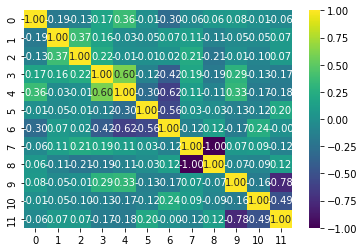

In [27]:
# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

# Normalización y estandarización automática

Con el fin de evitar que la magnitud de ciertos atributos dominen el proceso de entrenamiento, procedemos a estandarizar o normalizar los datos mediante las herramienta standarScaler del módulo `pyspark.ml.feature`: (10 puntos)

In [28]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df = scaled_df.drop("features")
scaled_df.show()


+-----------+------------------+-----+-----+------------------+--------+----------+----------+----------+--------+--------+--------+----------+--------+--------------------+
|PassengerId|               Age|SibSp|Parch|              Fare|Survived|Embarked_Q|Embarked_C|Embarked_S|Pclass_3|Pclass_1|Pclass_2|Sex_female|Sex_male|              scaled|
+-----------+------------------+-----+-----+------------------+--------+----------+----------+----------+--------+--------+--------+----------+--------+--------------------+
|          1|              22.0|    1|    0|              7.25|       0|       0.0|       0.0|       1.0|     1.0|     0.0|     0.0|       0.0|     1.0|(12,[0,1,3,6,8,11...|
|          2|              38.0|    1|    0|  71.2833023071289|       1|       0.0|       1.0|       0.0|     0.0|     1.0|     0.0|       1.0|     0.0|(12,[0,1,3,4,7,9]...|
|          3|              26.0|    0|    0| 7.925000190734863|       1|       0.0|       0.0|       1.0|     1.0|     0.0|     0.

In [29]:
depurated_df = scaled_df.withColumnRenamed("Survived", "label").withColumnRenamed("scaled","features")
depurated_df = depurated_df.select(['PassengerId','label','features'])
depurated_df.show()

+-----------+-----+--------------------+
|PassengerId|label|            features|
+-----------+-----+--------------------+
|          1|    0|(12,[0,1,3,6,8,11...|
|          2|    1|(12,[0,1,3,4,7,9]...|
|          3|    1|(12,[0,3,6,7,11],...|
|          4|    1|(12,[0,1,3,4,7,11...|
|          5|    0|(12,[0,3,6,8,11],...|
|          6|    0|(12,[0,3,6,8,10],...|
|          7|    0|(12,[0,3,4,8,11],...|
|          8|    0|[0.15524101534207...|
|          9|    1|(12,[0,2,3,6,7,11...|
|         10|    1|(12,[0,1,3,5,7,9]...|
|         11|    1|[0.31048203068415...|
|         12|    1|(12,[0,3,4,7,11],...|
|         13|    0|(12,[0,3,6,8,11],...|
|         14|    0|[3.02719979917052...|
|         15|    0|(12,[0,3,6,7,11],...|
|         16|    1|(12,[0,3,5,7,11],...|
|         17|    0|[0.15524101534207...|
|         18|    1|(12,[0,3,5,8,11],...|
|         19|    0|(12,[0,1,3,6,7,11...|
|         20|    1|(12,[0,3,6,7,9],[...|
+-----------+-----+--------------------+
only showing top

# Escritura a base de datos

Con los datos depurados se procede a escribir una tabla llamada tarea3 (con overwrite) del conjunto de datos que se utilizará como base para el entrenamiento. (10 puntos)

In [30]:
# Primero debo convertir la información del vector de features a columnas para poder almacenar en postgresql

features_df = depurated_df
features_df = features_df.rdd.map(lambda x:[float(y) for y in x['features']], preservesPartitioning=False).toDF(['Age', 'SibSp', 'Parch', 'Fare',
                                                                      'Pclass_1','Pclass_2','Pclass_3',
                                                                      'Sex_female', 'Sex_male',
                                                                      'Embarked_C','Embarked_Q','Embarked_S'])

features_df.show()

+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|               Age|             SibSp|             Parch|               Fare|          Pclass_1|          Pclass_2|          Pclass_3|        Sex_female|          Sex_male|       Embarked_C|       Embarked_Q|        Embarked_S|
+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
| 1.707651168762859|0.9600076272872313|               0.0|0.14012672975462784|               0.0|               0.0|2.0062033556173384|               0.0|2.0876945122017356|              0.0|              0.0|2.1808695222462156|
| 2.949579291499484|0.9600076272872313|               0.0| 1.3777511777115161|2.3186

In [31]:
# Se procede a almacenar el conjunto de datos limpio en la base de datos

features_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

In [32]:
# Como prueba del correcto almacenamiento cargamos el conjunto de datos tarea3 desde la base de datos de postgreSQL

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
features_df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

features_df.show()

+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|               Age|             SibSp|             Parch|               Fare|          Pclass_1|          Pclass_2|          Pclass_3|        Sex_female|          Sex_male|       Embarked_C|       Embarked_Q|        Embarked_S|
+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
| 1.707651168762859|0.9600076272872313|               0.0|0.14012672975462784|               0.0|               0.0|2.0062033556173384|               0.0|2.0876945122017356|              0.0|              0.0|2.1808695222462156|
| 2.949579291499484|0.9600076272872313|               0.0| 1.3777511777115161|2.3186

# Entrenamiento de modelos

Con los datos limpios cargados de la base de datos se procederá a entrenar dos modelos de clasificación: a) y b) utilizando el protocolo estándar de k-fold cross validation y dejando un conjunto adicional para validación final.

___
## Modelo de clasificación 1: train/test - MultilayerPerceptronClassifier
___

In [71]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator


# Split the data into train and test
splits = depurated_df.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 12 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [12, 5, 4, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.8480769230769231


In [72]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Split the data into train-val and test
splits = depurated_df.randomSplit([0.8, 0.2], 1234)
train = splits[0]
test = splits[1]

layers = [12, 5, 4, 2]
lr = MultilayerPerceptronClassifier()

grid = ParamGridBuilder() \
    .addGrid(lr.maxIter,[100]) \
    .addGrid(lr.layers, [layers]) \
    .addGrid(lr.blockSize,[128]) \
    .addGrid(lr.seed, [1234]) \
    .build()
evaluator = MulticlassClassificationEvaluator()
crossval = CrossValidator(estimator=lr, 
                          estimatorParamMaps=grid, 
                          evaluator=evaluator, 
                          parallelism=2,
                          numFolds=4)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

# compute accuracy on the test set
result = cvModel.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.875968992248062


## Evaluación de los resultados del primer modelo de clasificación y almacenamiento

Después de aplicar el algoritmo de clasificación de perceptrón multicapa, se puede observar que cambiando la proporción del split de train/test de 60/40 a 80/20 mejoró la métrica de 84.80 a 87.59. Procedemos por lo tanto a generar el almacenamiento de esta segunda corrida. (10 puntos)

In [73]:
# Imprime tabla del modelo 1 corrida 1

model1 = model.transform(test)
model1 = model1.select(['PassengerId','features','label', 'prediction'])
model1.show()

+-----------+--------------------+-----+----------+
|PassengerId|            features|label|prediction|
+-----------+--------------------+-----+----------+
|          2|(12,[0,1,3,4,7,9]...|    1|       1.0|
|          5|(12,[0,3,6,8,11],...|    0|       0.0|
|         22|(12,[0,3,5,8,11],...|    1|       0.0|
|         25|[0.62096406136831...|    0|       0.0|
|         26|[2.94957929149948...|    1|       1.0|
|         27|(12,[0,3,6,8,9],[...|    0|       0.0|
|         28|[1.47478964574974...|    0|       1.0|
|         37|(12,[0,3,6,8,9],[...|    1|       0.0|
|         46|(12,[0,3,6,8,11],...|    0|       0.0|
|         48|(12,[0,3,6,7,10],...|    1|       1.0|
|         53|(12,[0,1,3,4,7,9]...|    1|       1.0|
|         57|(12,[0,3,5,7,11],...|    1|       1.0|
|         58|(12,[0,3,6,8,9],[...|    0|       0.0|
|         59|[0.38810253835519...|    1|       1.0|
|         64|[0.31048203068415...|    0|       0.0|
|         67|(12,[0,3,5,7,11],...|    1|       1.0|
|         72

In [74]:
# Para almacenar los datos, primero debo convertir la información del vector de features a columnas para poder almacenar en postgresql


model1_features_df = model1.rdd.map(lambda x:[float(y) for y in x['features']], preservesPartitioning=False).toDF(['Age', 'SibSp', 'Parch', 'Fare',
                                                                      'Pclass_1','Pclass_2','Pclass_3',
                                                                      'Sex_female', 'Sex_male',
                                                                      'Embarked_C','Embarked_Q','Embarked_S'])

model1_features_df.show()

+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|                Age|             SibSp|             Parch|               Fare|          Pclass_1|          Pclass_2|          Pclass_3|        Sex_female|          Sex_male|       Embarked_C|       Embarked_Q|        Embarked_S|
+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  2.949579291499484|0.9600076272872313|               0.0| 1.3777511777115161|2.3186434852794338|               0.0|               0.0|2.0876945122017356|               0.0|2.470495342150998|              0.0|               0.0|
| 2.7167177684863666|               0.0|               0.0|0.15558899327611128| 

In [75]:
# Se procede a almacenar el conjunto de datos limpios del modelo 1 en la base de datos

model1_features_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1_features") \
    .save()

In [76]:
# Como prueba del correcto almacenamiento cargamos el conjunto de datos modelo 1 desde la base de datos de postgreSQL

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
model1_features_df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1_features") \
    .load()

model1_features_df.show()

+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|                Age|             SibSp|             Parch|               Fare|          Pclass_1|          Pclass_2|          Pclass_3|        Sex_female|          Sex_male|       Embarked_C|       Embarked_Q|        Embarked_S|
+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  2.949579291499484|0.9600076272872313|               0.0| 1.3777511777115161|2.3186434852794338|               0.0|               0.0|2.0876945122017356|               0.0|2.470495342150998|              0.0|               0.0|
| 2.7167177684863666|               0.0|               0.0|0.15558899327611128| 

In [77]:
# Para almacenar los resultados del modelo 1 se prepara el data frame sin el vector de features

model1_results = model1.select(['PassengerId','label', 'prediction'])
model1_results.show()

+-----------+-----+----------+
|PassengerId|label|prediction|
+-----------+-----+----------+
|          2|    1|       1.0|
|          5|    0|       0.0|
|         22|    1|       0.0|
|         25|    0|       0.0|
|         26|    1|       1.0|
|         27|    0|       0.0|
|         28|    0|       1.0|
|         37|    1|       0.0|
|         46|    0|       0.0|
|         48|    1|       1.0|
|         53|    1|       1.0|
|         57|    1|       1.0|
|         58|    0|       0.0|
|         59|    1|       1.0|
|         64|    0|       0.0|
|         67|    1|       1.0|
|         72|    0|       0.0|
|         73|    0|       0.0|
|         77|    0|       0.0|
|         85|    1|       1.0|
+-----------+-----+----------+
only showing top 20 rows



In [69]:
# Almacenar los resultados de modelo1 en la base de datos


model1_results \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1_results") \
    .save()

In [78]:
# Como prueba del correcto almacenamiento cargamos el conjunto de datos de resultados del modelo2 desde la base de datos de postgreSQL

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
model1_results = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1_results") \
    .load()

model1_results.show()

+-----------+-----+----------+
|PassengerId|label|prediction|
+-----------+-----+----------+
|          2|    1|       1.0|
|          5|    0|       0.0|
|         22|    1|       0.0|
|         25|    0|       0.0|
|         26|    1|       1.0|
|         27|    0|       0.0|
|         28|    0|       1.0|
|         37|    1|       0.0|
|         46|    0|       0.0|
|         48|    1|       1.0|
|         53|    1|       1.0|
|         57|    1|       1.0|
|         58|    0|       0.0|
|         59|    1|       1.0|
|         64|    0|       0.0|
|         67|    1|       1.0|
|         72|    0|       0.0|
|         73|    0|       0.0|
|         77|    0|       0.0|
|         85|    1|       1.0|
+-----------+-----+----------+
only showing top 20 rows



___
## Modelo de clasificación 2: train/test - LogisticRegression
___

In [79]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

# Split the data into train-val and test
splits = depurated_df.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

lr = LogisticRegression()

grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)

cvModel = cv.fit(train)

cvModel.getNumFolds()

cvModel.avgMetrics[0]

evaluator.evaluate(cvModel.transform(test))


0.8519230769230769

In [80]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

# Split the data into train-val and test
splits = depurated_df.randomSplit([0.8, 0.2], 1234)
train = splits[0]
test = splits[1]

lr = LogisticRegression()

grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)

cvModel = cv.fit(train)

cvModel.getNumFolds()

cvModel.avgMetrics[0]

evaluator.evaluate(cvModel.transform(test))


0.8604651162790697

## Evaluación de los resultados del segundo modelo de clasificación y almacenamiento

Después de aplicar el algoritmo de clasificación por regresión logística, se aprecia en este caso que igualmente se presenta una mejora en la métrica de accuracy al modificar la proporción del split de train/test de 60/40 a 80/20 pasando de 85.19 a 886.04 y, en terminos generales, el anterior modelo de perceptrón multicapa genera una mejor métrica de clasificación que la de este último modelo (87.59 versus 86.04 respectivamente). Procedemos seguidamente a generar el almacenamiento de la segunda corrida del modelo 2. (10 puntos)

In [83]:
model2 = cvModel.transform(test)
model2 = model2.select(['PassengerId','features','label','prediction'])
model2.show()

+-----------+--------------------+-----+----------+
|PassengerId|            features|label|prediction|
+-----------+--------------------+-----+----------+
|          2|(12,[0,1,3,4,7,9]...|    1|       1.0|
|          5|(12,[0,3,6,8,11],...|    0|       0.0|
|         22|(12,[0,3,5,8,11],...|    1|       0.0|
|         25|[0.62096406136831...|    0|       1.0|
|         26|[2.94957929149948...|    1|       1.0|
|         27|(12,[0,3,6,8,9],[...|    0|       0.0|
|         28|[1.47478964574974...|    0|       1.0|
|         37|(12,[0,3,6,8,9],[...|    1|       0.0|
|         46|(12,[0,3,6,8,11],...|    0|       0.0|
|         48|(12,[0,3,6,7,10],...|    1|       1.0|
|         53|(12,[0,1,3,4,7,9]...|    1|       1.0|
|         57|(12,[0,3,5,7,11],...|    1|       1.0|
|         58|(12,[0,3,6,8,9],[...|    0|       0.0|
|         59|[0.38810253835519...|    1|       1.0|
|         64|[0.31048203068415...|    0|       0.0|
|         67|(12,[0,3,5,7,11],...|    1|       1.0|
|         72

In [86]:
# Primero debo convertir la información del vector de features a columnas para poder almacenar en postgresql

model2_features_df = model2
model2_features_df = model2_features_df.rdd.map(lambda x:[float(y) for y in x['features']], preservesPartitioning=False).toDF(['Age', 'SibSp', 'Parch', 'Fare',
                                                                      'Pclass_1','Pclass_2','Pclass_3',
                                                                      'Sex_female', 'Sex_male',
                                                                      'Embarked_C','Embarked_Q','Embarked_S'])

model2_features_df.show()

+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|                Age|             SibSp|             Parch|               Fare|          Pclass_1|          Pclass_2|          Pclass_3|        Sex_female|          Sex_male|       Embarked_C|       Embarked_Q|        Embarked_S|
+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  2.949579291499484|0.9600076272872313|               0.0| 1.3777511777115161|2.3186434852794338|               0.0|               0.0|2.0876945122017356|               0.0|2.470495342150998|              0.0|               0.0|
| 2.7167177684863666|               0.0|               0.0|0.15558899327611128| 

In [87]:
# Se procede a almacenar el conjunto de datos limpios del modelo 2 en la base de datos

model2_features_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "model2_features") \
    .save()

In [88]:
# Como prueba del correcto almacenamiento cargamos el conjunto de datos modelo2 desde la base de datos de postgreSQL

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
model2_features_df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "model2_features") \
    .load()

model2_features_df.show()

+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|                Age|             SibSp|             Parch|               Fare|          Pclass_1|          Pclass_2|          Pclass_3|        Sex_female|          Sex_male|       Embarked_C|       Embarked_Q|        Embarked_S|
+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  2.949579291499484|0.9600076272872313|               0.0| 1.3777511777115161|2.3186434852794338|               0.0|               0.0|2.0876945122017356|               0.0|2.470495342150998|              0.0|               0.0|
| 2.7167177684863666|               0.0|               0.0|0.15558899327611128| 

In [89]:
# Para almacenar los resultados del modelo 2 se prepara el data frame sin el vector de features

model2_results = model2.select(['PassengerId','label', 'prediction'])
model2_results.show()

+-----------+-----+----------+
|PassengerId|label|prediction|
+-----------+-----+----------+
|          2|    1|       1.0|
|          5|    0|       0.0|
|         22|    1|       0.0|
|         25|    0|       1.0|
|         26|    1|       1.0|
|         27|    0|       0.0|
|         28|    0|       1.0|
|         37|    1|       0.0|
|         46|    0|       0.0|
|         48|    1|       1.0|
|         53|    1|       1.0|
|         57|    1|       1.0|
|         58|    0|       0.0|
|         59|    1|       1.0|
|         64|    0|       0.0|
|         67|    1|       1.0|
|         72|    0|       1.0|
|         73|    0|       0.0|
|         77|    0|       0.0|
|         85|    1|       1.0|
+-----------+-----+----------+
only showing top 20 rows



In [90]:
# Almacenar los resultados de modelo1 en la base de datos


model2_results \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2_results") \
    .save()

In [92]:
# Como prueba del correcto almacenamiento cargamos el conjunto de datos de resultados del modelo2 desde la base de datos de postgreSQL

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
model2_results = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2_results") \
    .load()

model2_results.show()

+-----------+-----+----------+
|PassengerId|label|prediction|
+-----------+-----+----------+
|          2|    1|       1.0|
|          5|    0|       0.0|
|         22|    1|       0.0|
|         25|    0|       1.0|
|         26|    1|       1.0|
|         27|    0|       0.0|
|         28|    0|       1.0|
|         37|    1|       0.0|
|         46|    0|       0.0|
|         48|    1|       1.0|
|         53|    1|       1.0|
|         57|    1|       1.0|
|         58|    0|       0.0|
|         59|    1|       1.0|
|         64|    0|       0.0|
|         67|    1|       1.0|
|         72|    0|       1.0|
|         73|    0|       0.0|
|         77|    0|       0.0|
|         85|    1|       1.0|
+-----------+-----+----------+
only showing top 20 rows



# Final